In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.shifting import computeShifting
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

# def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     sc = axis.scatter(pos[:,0], pos[:,1], s = 8, c = c)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
#     axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

# def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

#     sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(-1.05,1.05)
#     axis.set_ylim(-1.05,1.05)

In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.plotting import plotImplicitSDF
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorFieldGradient
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

u_mag = 2
config = {
    'domain': {
        'minExtent': [-3,-1],
        'maxExtent': [3,1],
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'compute':{
        'device': 'cuda'
    },
    'kernel':{
        'name': 'Wendland2',
    'targetNeighbors': 45.22,
    },
    "neighborhood":{
        "scheme": "compact"
    },
    # 'EOS':{
    #     'type': 'Tait',
    #     'kappa': 1.5
    # },
    'fluid':{
        'cs' : u_mag * 10
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'threshold': 0.05,
        'maxIterations': 1,
        'freeSurface': False
    },
    'diffusion':{
        'velocityScheme': 'deltaSPH_inviscid',
        'alpha': 0.010793905705213547
    },
    'boundary':{
        'active':True
    },
    'noise':{
    #     'n': nx,
        'baseFrequency': 1,
    #     'dim': 2,
        'octaves': 4,
    #     'persistence': 0.5,
    #     'lacunarity': 2,
    #     'seed': 23467586,
    #     'tileable': True,
    #     'kind': 'simplex',
    },
    'plot':{
        # 'mosaic': '''A''',
    #     'figSize': (6,5.5),
        'plots': {'A': {'val': 'fluidIndex', 'cbar': True, 'cmap': 'twilight', 'scale': 'lin', 'size': 0.1, 'gridVis' : False, 'title': 'Fluid Index'}},
    #     'export': True,
        'updateInterval': 32,
    #     'namingScheme': 'timestep',
    #     'exportPath': 'output',
    #     'gif': True,
        'fps': 1000,
    },
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)


from diffSPH.v2.modules.viscosity import computeViscosityParameter
targetRe = 1000
L = 2
if config['diffusion']['velocityScheme'] == 'deltaSPH_inviscid':
    nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']   / (2 * (config['domain']['dim'] + 2)) * 5/4
    Re = u_mag * (2 * L) / config['diffusion']['nu_sph']

    target_nu = u_mag * (2 * L) / targetRe
    alpha = target_nu / (config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4) #/ config['kernel']['kernelScale']
    config['diffusion']['alpha'] = alpha
    # print(alpha)
    if alpha < 0.01:
        print(rf'$\alpha = {alpha}$ is very low, consider increasing the value (should be > 0.01)')
elif config['diffusion']['velocityScheme'] == 'deltaSPH_viscid':
    nu_sph = config['diffusion']['nu']
    Re = u_mag * (2 * L) / config['diffusion']['nu']
    target_nu = u_mag * (2 * L) / targetRe
    config['diffusion']['nu'] = target_nu
       
config['diffusion']['nu_sph'] = computeViscosityParameter(None, config)# * config['kernel']['kernelScale']
config['diffusion']['Re'] = u_mag * (2 * L) / config['diffusion']['nu_sph']


{'domain': {'minExtent': tensor([-2., -1.], device='cuda:0'),
  'maxExtent': tensor([4., 1.], device='cuda:0'),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True], device='cuda:0')},
 'particle': {'nx': 64,
  'dx': tensor(0.0312, device='cuda:0'),
  'kernelScale': tensor(1.8970, device='cuda:0'),
  'defaultVolume': tensor(0.0010, device='cuda:0'),
  'defaultSupport': 0.11856059341027234,
  'volume': tensor(0.0010, device='cuda:0'),
  'support': 0.11856059341027234,
  'smoothingLength': tensor(0.0625, device='cuda:0')},
 'compute': {'device': 'cuda', 'precision': 'float32', 'dtype': torch.float32},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 45.22,
  'function': <diffSPH.kernels.KernelWrapper at 0x7f8256105850>,
  'kernelScale': tensor(1.8970, device='cuda:0')},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'fluid': {'cs': 20, 'rho0': 1000, 'mu': 0.1},
 'shifting': {'scheme': 'deltaSPH',
  'threshold': 0.05,
  'maxIterations': 1,
  'freeSurface

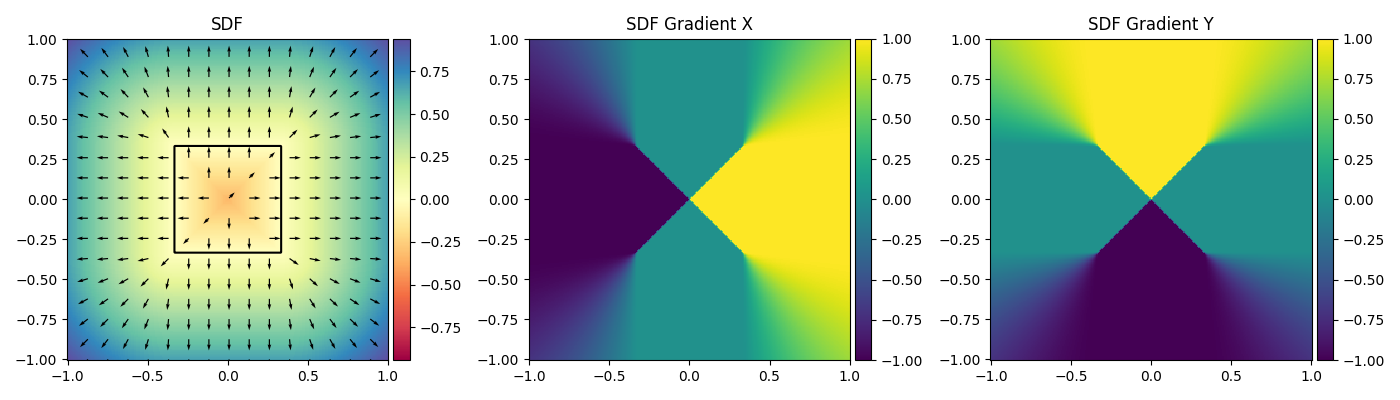

In [3]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_b
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [4]:
from diffSPH.v2.sampling import sampleNoisyParticles, sampleParticles
# particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = [])
particleState, mask = sampleParticles(config, sdfs = [])

particleState

{'numParticles': 12288,
 'positions': tensor([[-1.9844, -0.9844],
         [-1.9531, -0.9844],
         [-1.9219, -0.9844],
         ...,
         [ 3.9219,  0.9844],
         [ 3.9531,  0.9844],
         [ 3.9844,  0.9844]], device='cuda:0'),
 'areas': tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.9766, 0.9766, 0.9766,  ..., 0.9766, 0.9766, 0.9766], device='cuda:0'),
 'supports': tensor([0.1186, 0.1186, 0.1186,  ..., 0.1186, 0.1186, 0.1186], device='cuda:0'),
 'index': tensor([    0,     1,     2,  ..., 12285, 12286, 12287], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 

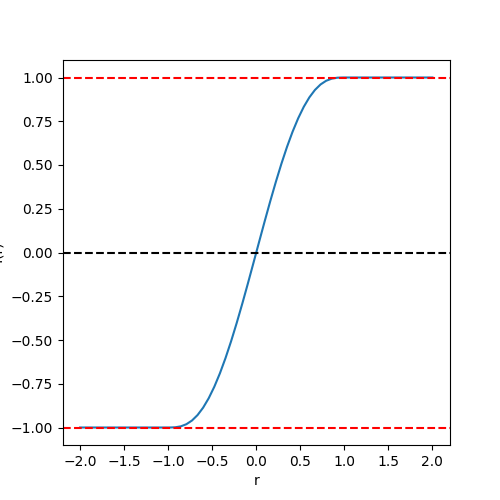

In [5]:
r = torch.linspace(-2, 2, 64, dtype = torch.float32)

fx = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
fx[r < -1] = -1
fx[r > 1] = 1

fig, axis = plt.subplots(1,1, figsize = (5,5))
axis.plot(r, fx)
axis.set_xlabel('r')
axis.set_ylabel('f(r)')
# axis.vlines(1, -1, 1, color = 'r', linestyle = '--')
axis.axhline(0, color = 'k', linestyle = '--')
axis.axhline(1, color = 'r', linestyle = '--')
axis.axhline(-1, color = 'r', linestyle = '--')


In [6]:
from  diffSPH.v2.sampling import sampleVelocityField, sampleNoise, filterParticlesWithSDF

def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions.cpu()).to(positions.device)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 #/ 0.5 + 1
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped /2 + 0.5) * (noise)


def rampOrthogonal(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions.cpu()).to(positions.device)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped) * (noise)

def filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree'):
    if kind == 'divergenceFree':
        return rampDivergenceFree(noiseState['positions'], noiseState['potential'], sdf, offset = noiseState['supports'], d0 = noiseState['supports'])
    else:
        return rampOrthogonal(noiseState['positions'], noiseState['potential'], sdf, offset = config['particle']['dx'] / 2, d0 = noiseState['supports'])
    

def sampleNoisyParticles(noiseConfig, config, sdfs = []):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    particlesA = particlesA.to(config['compute']['device'])
    volumeA = volumeA.to(config['compute']['device'])
    
    area = (4 / config['particle']['nx']**2)
    area = volumeA
    grid, noiseSimplex = sampleNoise(noiseConfig)

    noiseState = {}
    noiseState['numParticles'] = particlesA.shape[0]
    # noiseState['timestep'] = 0
    # noiseState['time'] = 0.
    # noiseState['dt'] = config['timestep']['dt']
    noiseState['positions'] = particlesA
    noiseState['areas'] = particlesA.new_ones(particlesA.shape[0]) * area
    noiseState['pressures'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['divergence'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['masses'] = noiseState['areas'] * config['fluid']['rho0']
    noiseState['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim']) * particlesA.new_ones(particlesA.shape[0])
    noiseState['index'] = torch.arange(particlesA.shape[0], device = particlesA.device)
    noiseState['densities'] = particlesA.new_ones(particlesA.shape[0]) * config['fluid']['rho0'] 
    noiseState['velocities'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    noiseState['accelerations'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    noiseState['potential'] = noiseSimplex.flatten().to(particlesA.device)


    fluidNeighborhood = neighborSearch(noiseState, noiseState, config)

    noiseState['neighborhood'] = fluidNeighborhood
    for sdf in sdfs:
        noiseState['potential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')
    noiseState['velocities'], noiseState['divergence'] = sampleVelocityField(noiseState,noiseState['neighborhood'])
    mask = torch.ones_like(noiseState['potential'], dtype = torch.bool)
    for sdf_func in sdfs:
        _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        mask = mask & maskA
    noiseState['velocities'][~mask, :] = 0

    _, noiseState['numNeighbors'] = countUniqueEntries(fluidNeighborhood['indices'][0], noiseState['positions'])

    return noiseState, mask

In [7]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs
from diffSPH.v2.util import printState

fluidState,_ = sampleParticles(config, sdfs = [])
# fluidState,_ = sampleNoisyParticles(config['noise'], config, sdfs = [sdf])
boundaryState = processBoundarySDFs(fluidState, config, [sdf], 'regular')

# display(boundaryState)
# printState(fluidState)

particleState = {
    'fluid': fluidState,
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

particleState['fluid']['velocities'] = particleState['fluid']['velocities'] / (torch.linalg.norm(particleState['fluid']['velocities'], dim = -1).max()) * u_mag

state = copy.deepcopy(particleState)

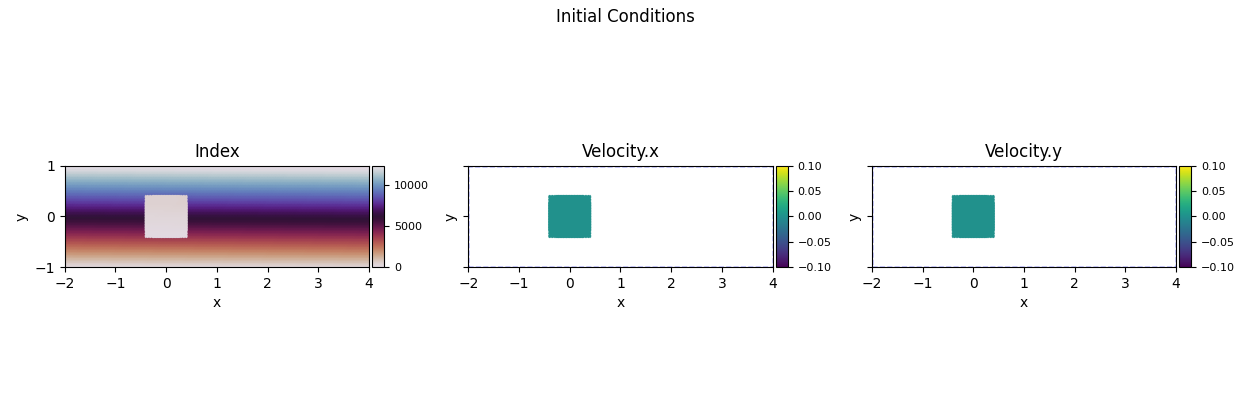

In [8]:
visualizationState = prepVisualizationState(particleState, config)
s = 8
fig, axis = plt.subplots(1, 3, figsize=(12.5,4), sharex = False, sharey = True, squeeze = False)

# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

plotVelX = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'index', mapping = '.x', which = 'all', scaling = 'lin',s = s, cmap = 'twilight_r', plotBoth=False)
plotVelY = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'velocities', mapping = '.x', which = 'all', scaling = 'lin',s = s, plotBoth=False)
plotVelMag = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'velocities', mapping = '.y',which = 'all', scaling = 'lin',s = s, plotBoth=False)

axis[0,0].set_title('Index')
axis[0,1].set_title('Velocity.x')
axis[0,2].set_title('Velocity.y')

fig.suptitle('Initial Conditions')
fig.tight_layout()

In [9]:
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

# for ax in axis.flatten():    
#     domainMin = config['domain']['minExtent']
#     domainMax = config['domain']['maxExtent']
#     square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
#     ax.add_patch(square)
#     ax.set_aspect('equal')
#     ax.set_xlim(-1.05,1.05)
#     ax.set_ylim(-1.05,1.05)

# axis[0,0].scatter(particleState['boundary']['positions'][:,0].detach().cpu().numpy(), particleState['boundary']['positions'][:,1].detach().cpu().numpy(), c = 'red', s = 2)
# axis[0,0].scatter(particleState['fluid']['positions'][:,0].detach().cpu().numpy(), particleState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', s = 4)

# # scatterPlotSymmetric(fig, axis[0,0], boundaryParticles, boundaryParticles.new_ones(boundaryParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
# # scatterPlotSymmetric(fig, axis[0,1], boundaryParticles, boundaryNormals[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
# # scatterPlotSymmetric(fig, axis[0,2], boundaryParticles, boundaryNormals[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8, cbar = False)

# fig.tight_layout()

In [10]:

from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices, computeCovarianceMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


In [11]:
# state = copy.deepcopy(particleState)

# with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
#     state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
#     _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

#     if config['boundary']['active']:
#         if not config['boundary']['static']:
#             state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
#             _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
#         state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
#         _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
#         state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
#         _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

In [12]:
# fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = True, squeeze = False)

# for ax in axis.flatten():
#     domainMin = config['domain']['minExtent']
#     domainMax = config['domain']['maxExtent']
#     square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
#     ax.add_patch(square)
#     ax.set_aspect('equal')
#     ax.set_xlim(-1.05,1.05)
#     ax.set_ylim(-1.05,1.05)

# sc = axis[0,0].scatter(state['fluid']['positions'][:,0].detach().cpu().numpy(), state['fluid']['positions'][:,1].detach().cpu().numpy(), c = state['fluid']['numNeighbors'], s = 2)
# cax = make_axes_locatable(axis[0,0]).append_axes("bottom", size="4%", pad="10%")
# fig.colorbar(sc, cax=cax,orientation='horizontal')

# sc = axis[0,1].scatter(state['fluid']['positions'][:,0].detach().cpu().numpy(), state['fluid']['positions'][:,1].detach().cpu().numpy(), c = state['boundaryToFluidNumNeighbors'], s = 2)
# cax = make_axes_locatable(axis[0,1]).append_axes("bottom", size="4%", pad="10%")
# fig.colorbar(sc, cax=cax,orientation='horizontal')

# sc = axis[0,2].scatter(state['boundary']['positions'][:,0].detach().cpu().numpy(), state['boundary']['positions'][:,1].detach().cpu().numpy(), c = state['fluidToBoundaryNumNeighbors'], s = 2)
# cax = make_axes_locatable(axis[0,2]).append_axes("bottom", size="4%", pad="10%")
# fig.colorbar(sc, cax=cax,orientation='horizontal')

# sc = axis[0,3].scatter(state['boundary']['positions'][:,0].detach().cpu().numpy(), state['boundary']['positions'][:,1].detach().cpu().numpy(), c = state['boundary']['numNeighbors'], s = 2)
# cax = make_axes_locatable(axis[0,3]).append_axes("bottom", size="4%", pad="10%")
# fig.colorbar(sc, cax=cax,orientation='horizontal')

# fig.tight_layout()

In [13]:
from diffSPH.v2.modules.density import computeDensity


def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
    if not config['boundary']['active']:
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'all':
        if not config['boundary']['active']:
            return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
        else:
            ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
            # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
            btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
            # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
            btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
            # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
            ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
            # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

            if reduce == 'sum':
                return ftf + btf, btb + ftb
            elif reduce == 'min':
                return torch.min(ftf, btf), torch.min(btb, ftb)
            elif reduce == 'max':
                return torch.max(ftf, btf), torch.max(btb, ftb)
            else:
                raise ValueError(f"Invalid reduce {reduce}")
            
    if direction == 'fluid':
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'fluidwBoundary':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'boundary':
        return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
    if direction == 'boundarywFluid':
        btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
        ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return None, btb + ftb
        elif reduce == 'min':
            return None, torch.min(btb, ftb)
        elif reduce == 'max':
            return None, torch.max(btb, ftb)
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'fluidToBoundary':
        return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
    if direction == 'boundaryToFluid':
        return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
    if direction == 'oneWay':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    raise ValueError(f"Invalid direction {direction}")


In [14]:
# fluidDensity, boundaryDensity = callModule(state, computeDensity, config, 'all')
# boundaryDensity = torch.zeros(state['boundary']['positions'].shape[0], device = state['boundary']['positions'].device)

In [15]:
# visualizationState = prepVisualizationState(state, config)

# fig, axis = plt.subplots(1, 1, figsize=(6.5,6), sharex = False, sharey = True, squeeze = False)

# plotIndex = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, (fluidDensity, boundaryDensity), which = 'all', scaling = 'lin')
# # updatePlot(plotIndex, visualizationState, 'densities')

# fig.tight_layout()

In [16]:

# with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
#     Mfluid, _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
#     state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(Mfluid)


# btf_gradRho, _ = callModule(state, densityGradient, config, 'boundaryToFluid')
# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

# state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

# state['fluid']['densityDiffusion'], state['boundary']['densityDiffusion'] = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'densityOnly')
# # if config['diffusion']['densityScheme'] == 'deltaSPH':
# #     fluidDeltaTerm, _ = callModule(state, computeDensityDeltaTerm, config, 'fluid', schemeOverride = 'deltaOnly')
# #     _, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'boundary', schemeOverride = 'denormalizedOnly')
# #     state['fluid']['densityDiffusion'] += fluidDeltaTerm
# #     state['boundary']['densityDiffusion'] += boundaryDeltaTerm
# # if config['diffusion']['densityScheme'] == 'denormalized':
# fluidDeltaTerm, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'denormalizedOnly')
# state['fluid']['densityDiffusion'] += fluidDeltaTerm
# state['boundary']['densityDiffusion'] += boundaryDeltaTerm

In [17]:
# k = 2.0 * np.pi
# state['fluid']['densities'] = config['fluid']['rho0'] * (2 + torch.cos(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1]))
# state['boundary']['densities'] = config['fluid']['rho0'] * (2 + torch.cos(k * state['boundary']['positions'][:,0]) * torch.cos(k * state['boundary']['positions'][:,1]))


# # state['fluid']['densities'][:] = config['fluid']['rho0']
# # state['boundary']['densities'][:] = 4 * config['fluid']['rho0']

In [18]:
# visualizationState = prepVisualizationState(state, config)
# s = 8
# fig, axis = plt.subplots(1, 1, figsize=(6.5,6), sharex = False, sharey = True, squeeze = False)

# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

# plotIndex = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'densities', which = 'all', scaling = 'lin',s = s)
# # plotIndex = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'gradRho', mapping = '.x', which = 'all', scaling = 'lin',s = s)
# # plotIndex = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'gradRho', mapping = '.y',which = 'all', scaling = 'lin',s = s)

# axis[0,0].set_title('Density')
# # axis[0,1].set_title('Density Gradient X')
# # axis[0,2].set_title('Density Gradient Y')


# fig.tight_layout()

In [19]:
# for i in tqdm(range(512)):        
#     with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
#         state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
#         state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])

#     state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
#     state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid', schemeOverride = 'densityOnly')

#     state['fluid']['densities'] += 0.01 * state['fluid']['densityDiffusion']
#     # state['boundary']['densities'] += 0.01 * state['boundary']['densityDiffusion']
#     if i%16 == 0:
#         visualizationState = prepVisualizationState(state, config)
#         updatePlot(plotIndex, visualizationState, 'densities')

#         fig.canvas.draw()
#         fig.canvas.flush_events()

In [20]:
# k = 2.0 * np.pi
# state['fluid']['densities'][:] = config['fluid']['rho0']# * (2 + torch.cos(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1]))
# state['boundary']['densities'][:] = config['fluid']['rho0']# * (2 + torch.cos(k * state['boundary']['positions'][:,0]) * torch.cos(k * state['boundary']['positions'][:,1]))

# state['fluid']['velocities'][:,0] = 2.0 * torch.sin(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1])
# state['fluid']['velocities'][:,1] = 2.0 * torch.cos(k * state['fluid']['positions'][:,1]) * torch.sin(k * state['fluid']['positions'][:,0])
# state['boundary']['velocities'][:,0] = 0.0
# state['boundary']['velocities'][:,1] = 0.0

# # state['fluid']['densities'][:] = config['fluid']['rho0']
# # state['boundary']['densities'][:] = 4 * config['fluid']['rho0']

In [21]:
# visualizationState = prepVisualizationState(state, config)
# s = 8
# fig, axis = plt.subplots(1, 3, figsize=(12.5,4), sharex = False, sharey = True, squeeze = False)

# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

# plotVelX = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'velocities', mapping = '.x', which = 'all', scaling = 'lin',s = s)
# plotVelY = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'velocities', mapping = '.y', which = 'all', scaling = 'lin',s = s)
# plotVelMag = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'velocities', mapping = 'L2',which = 'all', scaling = 'lin',s = s)

# axis[0,0].set_title('Density')
# # axis[0,1].set_title('Density Gradient X')
# # axis[0,2].set_title('Density Gradient Y')


# fig.tight_layout()

In [22]:
# for i in tqdm(range(512)):
#     state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')
#     state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'all')
#     state['fluid']['velocities'] += 0.1 * state['fluid']['velocityDiffusion']
#     # state['boundary']['velocities'] += 0.01 * state['boundary']['velocityDiffusion']
#     if i%16 == 0:
#         visualizationState = prepVisualizationState(state, config)
#         updatePlot(plotVelX, visualizationState, 'velocities')
#         updatePlot(plotVelY, visualizationState, 'velocities')
#         updatePlot(plotVelMag, visualizationState, 'velocities')

#         fig.canvas.draw()
#         fig.canvas.flush_events()

In [58]:
def simulationStep(state, config):
    state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
    _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

    if config['boundary']['active']:
        if not config['boundary']['static']:
            state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
            _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
        state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

    if config['simulation']['densityScheme'] == 'summation':
        state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
    # with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
    state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])

    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
    state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')

    # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
    state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

    state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')

    state['fluid']['pressures'] = computeEOS(state['fluid'], config)
    if 'boundary' in state:
        state['boundary']['pressures'] = computeEOS(state['boundary'], config)

    state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')

    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')
    state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)


    #         if config['SPS']['active']:
    #             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    minD = config['domain']['minExtent'][0].to(config['compute']['device'])
    maxD = config['domain']['maxExtent'][0].to(config['compute']['device'])
    xmod = torch.remainder(state['fluid']['positions'][:,0] - minD, maxD - minD) + minD

    dist = torch.min(xmod - minD, maxD - xmod)
    # ramp = 1 - (torch.clamp(dist, max = 1) / 1)**2    
    ramp = 1.25 - torch.clamp(dist, max = 1.25) / 1
    ramp = torch.clamp(ramp, max = 1)

    u_mag = 2
    diff_ux = u_mag - state['fluid']['velocities'][:,0]
    rampTime = 1
    forcing = diff_ux / rampTime * ramp 
    forcing = torch.where(ramp == 1,(u_mag - state['fluid']['velocities'][:,0]) / state['dt'], forcing)
    # if ramp == 1:
        # forcing = (u_mag - state['fluid']['velocities'][:,0]) / state['dt']



    # dist_to_boundary = torch.min(xmod, 2 - xmod)

    dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
    drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

    dudt[:,0] += forcing

    diff_ux = - state['fluid']['velocities'][:,1]
    rampTime = 1
    forcing = diff_ux / rampTime * ramp 

    # forcing = torch.where(ramp == 1, - state['fluid']['velocities'][:,1] / state['dt'], forcing)
    # if ramp == 1:
        # forcing = (- state['fluid']['velocities'][:,0]) / state['dt']
    dudt[:,1] += forcing

    boundary_dudt = state['boundary']['pressureAccel'] + state['boundary']['velocityDiffusion']
    boundary_drhodt = state['boundary']['momentumEquation']

    return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)

In [59]:
k = 1.0 * np.pi
state['fluid']['densities'][:] = config['fluid']['rho0']# * (2 + torch.cos(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1]))
# state['boundary']['densities'][:] = config['fluid']['rho0']# * (2 + torch.cos(k * state['boundary']['positions'][:,0]) * torch.cos(k * state['boundary']['positions'][:,1]))
u_mag = 2

# state['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * state['fluid']['positions'][:,0]) * torch.sin(k * state['fluid']['positions'][:,1])
# state['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1])


# state['fluid']['velocities'][:,0] = 2.0 * torch.sin(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1])
# state['fluid']['velocities'][:,1] = 2.0 * torch.cos(k * state['fluid']['positions'][:,1]) * torch.sin(k * state['fluid']['positions'][:,0])
# state['boundary']['velocities'][:,0] = 0.0
# state['boundary']['velocities'][:,1] = 0.0

perennialState = copy.deepcopy(state)
perennialState['fluid']['velocities'][:,0] = 0
perennialState['fluid']['velocities'][:,1] = 0
priorState = None

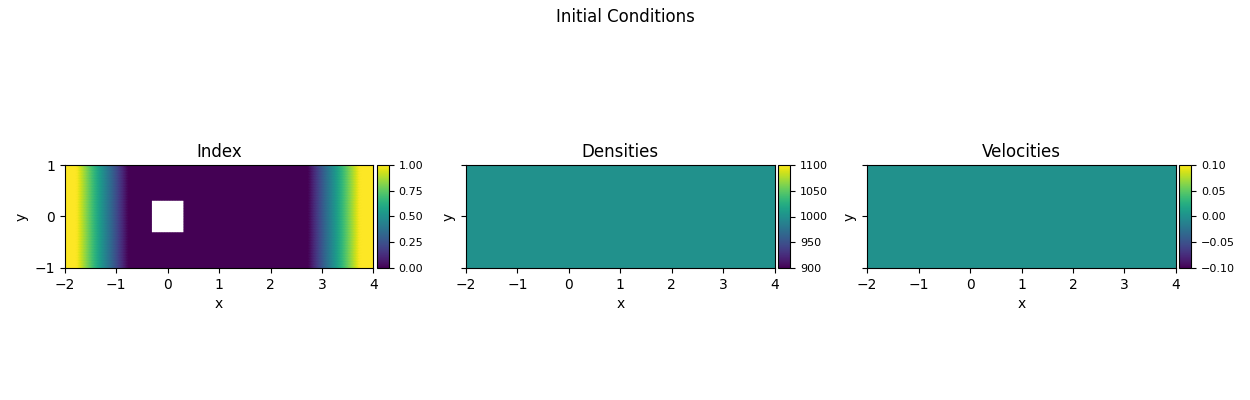

In [60]:
visualizationState = prepVisualizationState(perennialState, config)
s = 8
fig, axis = plt.subplots(1, 3, figsize=(12.5,4), sharex = False, sharey = True, squeeze = False)

# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')


xmod = abs(torch.clamp(abs(mod(state['fluid']['positions'][:,0] - 2, -2, 2)), max = 1) - 1) * 2


minD = config['domain']['minExtent'][0].to(config['compute']['device'])
maxD = config['domain']['maxExtent'][0].to(config['compute']['device'])
xmod = torch.remainder(perennialState['fluid']['positions'][:,0] - minD, maxD - minD) + minD

dist = torch.min(xmod - minD, maxD - xmod)
ramp = 1.25 - torch.clamp(dist, max = 1.25) / 1
ramp = torch.clamp(ramp, max = 1)

u_mag = 2
diff_ux = u_mag - perennialState['fluid']['velocities'][:,0]
rampTime = 4
forcing = diff_ux / rampTime * ramp 
# forcing[:] = xmod

plotVelX = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, ramp, mapping = '.x', which = 'fluid', scaling = 'lin',s = s, cmap = 'viridis', plotBoth=False)


plotVelY = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'densities', mapping = '.x', which = 'all', scaling = 'lin',s = s)
plotVelMag = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'velocities', mapping = 'L2',which = 'all', scaling = 'lin',s = s)

axis[0,0].set_title('Index')
axis[0,1].set_title('Densities')
axis[0,2].set_title('Velocities')

fig.suptitle('Initial Conditions')
fig.tight_layout()

In [61]:
perennialState['fluid']['velocities'][:,0] = 0
perennialState['fluid']['velocities'][:,1] = 0

In [62]:
config['fluid']

{'cs': 20, 'rho0': 1000, 'mu': 0.1}

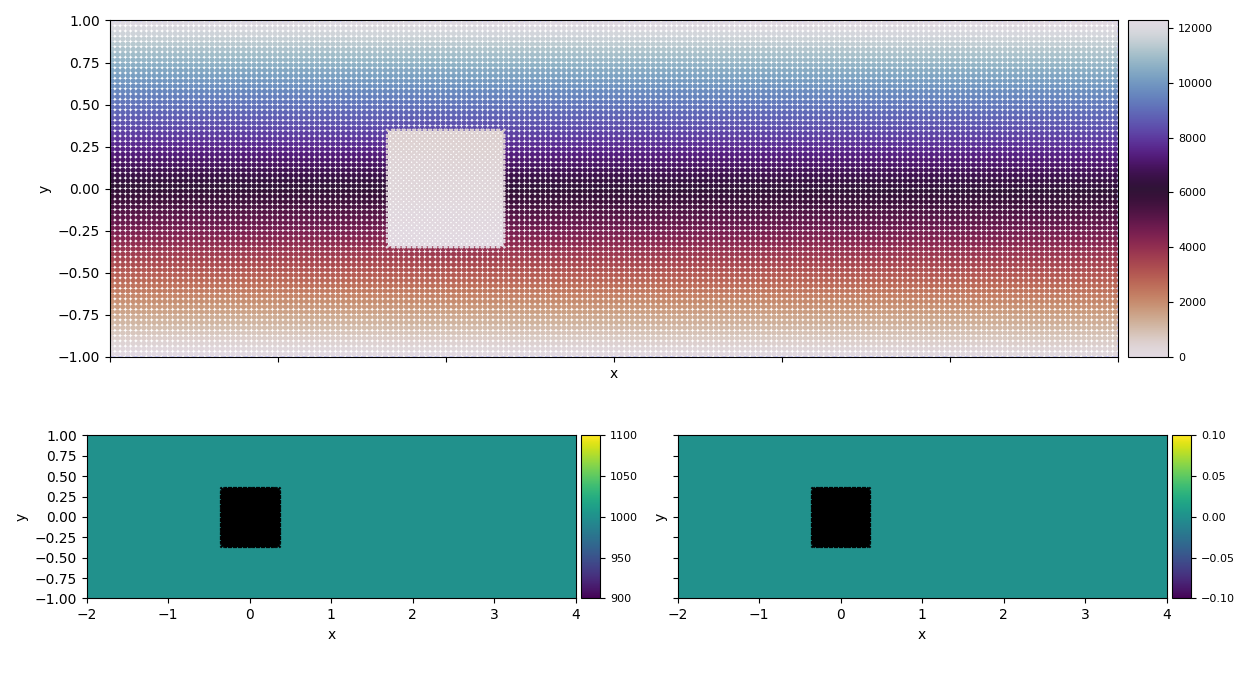

In [63]:
visualizationState = prepVisualizationState(perennialState, config)
s = 4

fig, axis = plt.subplot_mosaic('''AA
                              BC''',
                              figsize=(12.5,7), sharex = True, sharey = True)

# fig, axis = plt.subplots(1, 3, figsize=(12.5,4), sharex = False, sharey = True, squeeze = False)

# state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

plotVelX = visualizeParticleQuantity(fig, axis['A'], config, visualizationState, 'index', mapping = '.x', which = 'both', scaling = 'lin',s = s*2, cmap = 'twilight_r', plotBoth=False)
plotVelY = visualizeParticleQuantity(fig, axis['B'], config, visualizationState, 'densities', mapping = '.x', which = 'fluid', scaling = 'lin',s = s,  gridVisualization=False)
plotVelMag = visualizeParticleQuantity(fig, axis['C'], config, visualizationState, 'velocities', mapping = 'L2',which = 'fluid', scaling = 'lin',s = s, gridVisualization=False)

# axis['A'].set_title('Index')
# axis['B'].set_title('Densities')
# axis['C'].set_title('Velocities')

# fig.suptitle('Initial Conditions')
fig.tight_layout()

In [64]:
# visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(plotVelX, visualizationState, 'index')
# updatePlot(plotVelY, visualizationState, 'densities')
# updatePlot(plotVelMag, visualizationState, 'velocities')

In [65]:

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep
import datetime
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)

for i in tqdm(range(8192)):
# while(True):
    # perennialState, *priorState = integrate(simulationStep_wSPS, perennialState, config, previousStep= priorState)
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['positions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    if perennialState["timestep"] % 32 == 0:       

        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotVelX, visualizationState, 'index')
        updatePlot(plotVelY, visualizationState, 'densities')
        updatePlot(plotVelMag, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)
        # fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)
# savedStates.append(copy.deepcopy(perennialState))

  0%|          | 0/8192 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [124,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/winchenbach/dev/diffSPH/src/diffSPH/v2/util.py", line 16, in countUniqueEntries
        tuple: A tuple containing the unique indices and their counts.
    """
    ii, nit = torch.unique(indices, return_counts=True)
              ~~~~~~~~~~~~ <--- HERE
    ni = torch.zeros(positions.shape[0], dtype=nit.dtype, device=positions.device)
    ni[ii] = nit
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/torch/functional.py", line 981, in _return_counts
        return _unique_impl(input, sorted, return_inverse, return_counts, dim)

    output, _, counts = _unique_impl(input, sorted, return_inverse, return_counts, dim)
                        ~~~~~~~~~~~~ <--- HERE
    return output, counts
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/torch/functional.py", line 905, in _unique_impl
        )
    else:
        output, inverse_indices, counts = torch._unique2(
                                          ~~~~~~~~~~~~~~ <--- HERE
            input,
            sorted=sorted,
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [33]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

Creating video from  frames (frame count: 128)
Creating gif palette
Creating gif
Done


In [34]:
perennialState

{'fluid': {'numParticles': 3840,
  'positions': tensor([[-0.3754,  0.2714],
          [-1.7770, -0.4228],
          [-1.9738, -0.5659],
          ...,
          [-0.3077,  2.4870],
          [-0.2084,  2.4747],
          [-0.3213,  2.5412]], device='cuda:0'),
  'areas': tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010], device='cuda:0'),
  'pressures': tensor([1923.5107, 1947.8516, 1938.9893,  ..., 1920.3125, 1915.8936,
          1923.9990], device='cuda:0'),
  'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
  'masses': tensor([0.9766, 0.9766, 0.9766,  ..., 0.9766, 0.9766, 0.9766], device='cuda:0'),
  'supports': tensor([0.1186, 0.1186, 0.1186,  ..., 0.1186, 0.1186, 0.1186], device='cuda:0'),
  'index': tensor([   0,    1,    2,  ..., 4093, 4094, 4095], device='cuda:0'),
  'densities': tensor([1004.8088, 1004.8695, 1004.8477,  ..., 1004.8005, 1004.7895,
          1004.8101], device='cuda:0'),
  'velocities': tensor([[ 0.0127,  0.0068],
          [-0.1

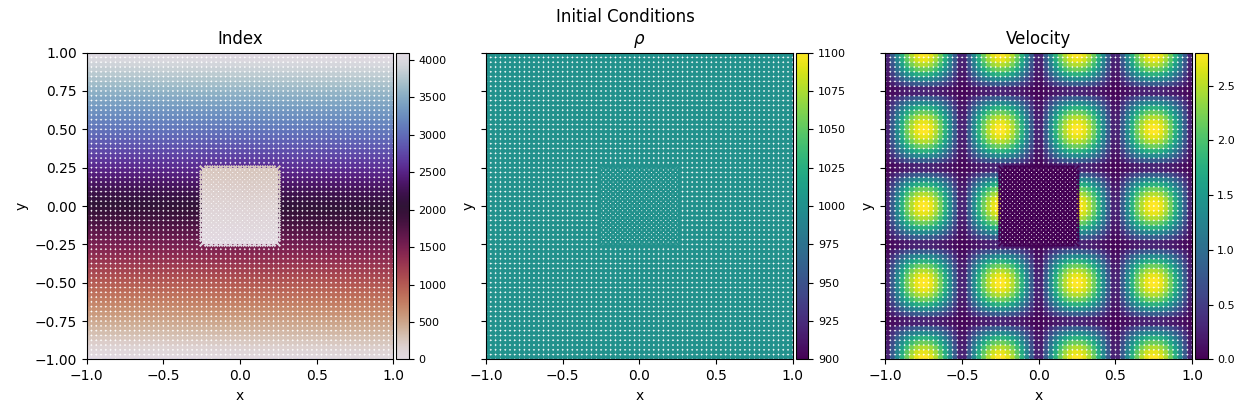

In [29]:
visualizationState = prepVisualizationState(perennialState, config)
s = 8
fig, axis = plt.subplots(1, 3, figsize=(12.5,4), sharex = False, sharey = True, squeeze = False)

state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

plotVelX = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'index', mapping = '.x', which = 'all', scaling = 'lin',s = s, cmap = 'twilight_r')
plotVelY = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'densities', mapping = '.y', which = 'all', scaling = 'lin',s = s)
plotVelMag = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'velocities', mapping = 'L2',which = 'all', scaling = 'lin',s = s)

axis[0,0].set_title('Index')
axis[0,1].set_title('$\\rho$')
axis[0,2].set_title('Velocity')

fig.suptitle('Initial Conditions')
fig.tight_layout()
# perennialState = copy.deepcopy(state)
# priorState = None

In [ ]:

# def simulationStep(simulationState, config):
#     with record_function("[SPH] - deltaSPH"):
#         with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
#             simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
#             _, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])
        
#         with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
#             simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
#             simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
#         # simulationState['fluidGradRho'] = sphOperationStates(stateA, stateB, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
        
#         with record_function("[SPH] - deltaSPH (3 - Diffusion)"):
#             simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
#             simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)

#         with record_function("[SPH] - deltaSPH (4 - Momentum + Pressure)"):
#             simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)
#             simulationState['fluidPressures'] = computeEOS(simulationState, config)

#             if config['deltaSPH']['pressureSwitch']:
#                 # simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
#                 simulationState['fluidFreeSurface']= detectFreeSurfaceBarecasco(simulationState, config)
#                 (i,j) = simulationState['fluidNeighborhood']['indices']
#                 numParticles = simulationState['numParticles']
#                 simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)
#                 simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
#             else:
#                 simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)

#         with record_function("[SPH] - deltaSPH (5 - Compute Divergence)"):
#             simulationState['fluidDivergence'] = sphOperationStates(stateA, stateB, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')
#         with record_function("[SPH] - deltaSPH (6 - Gravity)"):
#             simulationState['fluidGravityAccel'] = computeGravity(simulationState, config)
#         if config['SPS']['active']:
#             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
#                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
#                 simulationState['fluidVelocityDiffusion'] += simulationState['fluidSPSTurbulence']

#         with record_function("[SPH] - deltaSPH (8 - Update)"):
#             dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel'] + simulationState['fluidVelocityDiffusion']
#             drhodt = simulationState['fluidMomentumEquation'] + simulationState['fluidDensityDiffusion']
            
#             return simulationState['fluidVelocities'].clone(), dudt, drhodt

# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]